In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import DataProducer as dp

## 随机生成二维数据，分为四类

In [2]:
xy1=np.asarray(dp.GeneratePointInCycle1(50,1,1,1,1))
xy2=np.asarray(dp.GeneratePointInCycle1(50,2.5,2,-2,1))
xy3=np.asarray(dp.GeneratePointInCycle1(50,1.5,-2,-2))
xy4=np.asarray(dp.GeneratePointInCycle1(50,1.5,-2,1.5,1))

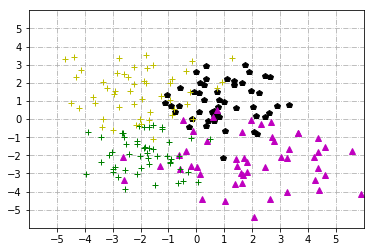

In [7]:
dp.DrawPointsAll(xy1,xy2,xy3,xy4)

## 每类别取前40个为训练样本，堆叠成训练集

In [10]:
train_data = xy1[:40,:]
train_data=np.vstack([train_data,xy2[:40,:],xy3[:40,:],xy4[:40,:]])
print(train_data.shape)

(160, 2)


## 生成标签

In [12]:
labels = np.ones(40)
labels = np.concatenate((labels,np.ones(40)*2,np.ones(40)*3,np.ones(40)*4))
print(labels.shape)

(160,)


## kNN 分类器代码 
来自机器学习实践

In [27]:
import operator
def classify0(inX, dataSet, labels, k):
    dataSetSize = dataSet.shape[0] # 训练集数量 n // 假设 dataSet.shape = [n,m]
    diffMat = np.tile(inX, (dataSetSize,1)) - dataSet # 测试数据扩展n倍成 训练集等大小，矩阵相减
    sqDiffMat = diffMat**2 # 差异矩阵 平方
    sqDistances = sqDiffMat.sum(axis=1) # 每行累加，最终成为一列，axis=1意味着逐列操作
    distances = sqDistances**0.5 # 开根号
    sortedDistIndicies = distances.argsort() # 排序取序号
    print("最接近节点序号排序组：\n",sortedDistIndicies,'\n')
    classCount={}# 表决字典
    for i in range(k): # 前k位，多数表决
        voteIlabel = labels[sortedDistIndicies[i]]
        classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    #print(sortedClassCount)
    return int(sortedClassCount[0][0])

In [52]:
# 只能处理一个test case per time
test_data = xy1[49,:]
print("label = {}".format(classify0(test_data,train_data,labels,7)))

最接近节点序号排序组：
 [ 31  15  13 128 120 122   9 141  79 131  10  16   5 154 125 152  38  89
   8 135 133  27  91 124 136  12 111  39 155   1  75 112 138 130  35  52
  19  33   2  22  36  37  11 137   3   4 121  97 150 143 129 159 153 105
  88 115  34  54 144  17  80 108 123  85 156  98 106  93 151 158 146  21
 116  50 139 127  83 126  86 114 113 157  29  55  18 149  64 118   0 102
  90  96  94  26 103 142  30  92 140 101  24  76  42  59 134   6  14  25
  74  20 119  78  23 147  87  40  46 145 148  32  56  70   7 100  82 117
  44  81  69  49  60  84 109  28 107  99 110  45  65 132  62  95  57 104
  43  47  58  51  41  77  48  72  73  68  61  53  67  63  71  66] 

label = 1


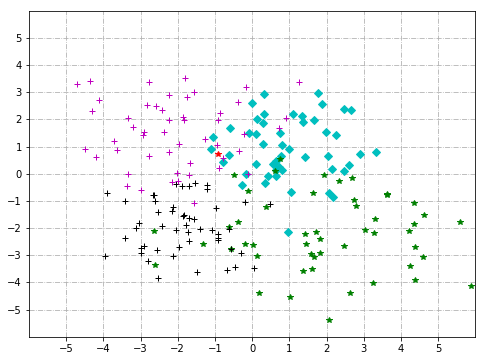

In [63]:
plt.figure(figsize=(8,6))
t = xy1[:49,:]
plt.plot(test_data[0],test_data[1],'r*')
dp.DrawPointsAll(t,xy2,xy3,xy4)

在面对海量训练集时，用线性搜索寻找最邻近点是不现实的。
为了解决搜索时间随训练集增大而膨胀的问题，需要使用加快搜索的数据结构，比如kd-tree。

## kd tree code from scipy

In [ ]:
class KdTree(object):
    def __init__(self, data, leafsize=6):
        '''
            data: Matrix shape n*m, n size  m-dimension train data
            leafsize:
            -----------
            maxes: current max feature val in data[dix] // array-like
            mins: min same above
            tree: the final structure
        '''
        self.data = np.asarray(data)
        #print(type(self.data),self.data.shape)
        self.n,self.m = np.shape(self.data)
        self.leafsize = int( leafsize )
        if self.leafsize<1:
            raise ValueError("Leafsize must be greater than 0")
        self.maxes = np.amax(self.data, axis = 0)
        self.mins  = np.amin(self.data, axis = 0)
        
        self.tree = self.__build(np.arange(self.n),self.maxes,self.mins)
    
    class leafnode(object):
        def __init__(self,idx):
            self.idx = idx
            self.children = len(idx)
            
    class innernode(object):
        def __init__(self, split_dim, split_val, less, greater):
            self.split_dim = split_dim
            self.split_val = split_val
            self.less = less
            self.greater = greater
            self.children = less.children + greater.children

        
    def __build(self, idx, maxes, mins):
        '''
            tree building in recursion
        '''
        
        if len(idx) <= self.leafsize:
            return KdTree.leafnode(idx)
        else:
            data = self.data[idx]
            
            d = np.argmax(maxes - mins) # choose the most wide range feature as split point
            max_val = maxes[d]
            min_val = mins[d]
            
            if max_val == min_val:
                return KdTree.leafnode(idx)
            
            data = data[:,d] # only care about this col
            
            split_val = (max_val+min_val)/2
            less_idx = np.nonzero(data <= split_val)[0]
            greater_idx = np.nonzero(data > split_val)[0]
            
            if len(less_idx) == 0 :
                split_val = np.amin(data)
                less_idx = np.nonzero(data<=split_val)[0]
                greater_idx = np.nonzero(data > split_val)[0]
            if len(greater_idx) == 0 :
                split_val = np.amax(data)
                less_idx = np.nonzero(data<split_val)[0]
                greater_idx = np.nonzero(data >= split_val)[0]
            
            if len(less_idx) == 0 :
                # all of data-array have the same val
                if not np.all(data == data[0]):
                    raise ValueError("Troublesome data array")
                split_val = data[0]
                less_idx = np.arange(len(data)-1)
                greater_idx = np.array([len(data)-1])
            
            ## why do following steps? reason?
            ## Ans: maxes/mins we get first time are already global
            ## every time we only make a split in a feature
            ## all we need to do is to refix this feat with split val 
            lessmaxes = np.copy(maxes)
            lessmaxes[d] = split_val
            greatermins = np.copy(mins)
            greatermins[d] = split_val
            return KdTree.innernode(d,split_val,
                                   self.__build(idx[less_idx],lessmaxes,mins),
                                   self.__build(idx[greater_idx],maxes,greatermins)
                                   )
    def query(self, x, k=1, eps=0, p=2, distance_upper_bound=np.inf):
        side_distances = np.maximum(0,np.maximum(x-self.maxes,self.mins-x))
        return side_distances
    def _query(self, x, k=1, eps=0, p=2, distance_upper_bound=np.inf):

        side_distances = np.maximum(0,np.maximum(x-self.maxes,self.mins-x))
        if p != np.inf:
            side_distances **= p
            min_distance = np.sum(side_distances)
        else:
            min_distance = np.amax(side_distances)

        # priority queue for chasing nodes
        # entries are:
        #  minimum distance between the cell and the target
        #  distances between the nearest side of the cell and the target
        #  the head node of the cell
        q = [(min_distance,
              tuple(side_distances),
              self.tree)]
        
        print(min_distance,tuple(side_distances),"tree root")
        # priority queue for the nearest neighbors
        # furthest known neighbor first
        # entries are (-distance**p, i)
        neighbors = []

        if eps == 0:
            epsfac = 1
        elif p == np.inf:
            epsfac = 1/(1+eps)
        else:
            epsfac = 1/(1+eps)**p

        if p != np.inf and distance_upper_bound != np.inf:
            distance_upper_bound = distance_upper_bound**p

        while q:
            min_distance, side_distances, node = heappop(q)
            if isinstance(node, KdTree.leafnode):
                # brute-force
                data = self.data[node.idx]
                ds = minkowski_distance_p(data,x[np.newaxis,:],p)
                print("in leafnode ",data)
                print("mink dis",ds)
                for i in range(len(ds)):
                    if ds[i] < distance_upper_bound:
                        if len(neighbors) == k:
                            heappop(neighbors)
                        heappush(neighbors, (-ds[i], node.idx[i]))
                        if len(neighbors) == k:
                            distance_upper_bound = -neighbors[0][0]
            else:
                # we don't push cells that are too far onto the queue at all,
                # but since the distance_upper_bound decreases, we might get
                # here even if the cell's too far
                if min_distance > distance_upper_bound*epsfac:
                    # since this is the nearest cell, we're done, bail out
                    break
                # compute minimum distances to the children and push them on
                if x[node.split_dim] < node.split_val:
                    near, far = node.less, node.greater
                else:
                    near, far = node.greater, node.less
                
                print("innernode: ",x[node.split_dim],node.split_val)
                
                # near child is at the same distance as the current node
                heappush(q,(min_distance, side_distances, near))

                # far child is further by an amount depending only
                # on the split value
                sd = list(side_distances)
                if p == np.inf:
                    min_distance = max(min_distance, abs(node.split-x[node.split_dim]))
                elif p == 1:
                    sd[node.split_dim] = np.abs(node.split_val-x[node.split_dim])
                    min_distance = min_distance - side_distances[node.split_dim] + sd[node.split_dim]
                else:
                    sd[node.split_dim] = np.abs(node.split_val-x[node.split_dim])**p
                    min_distance = min_distance - side_distances[node.split_dim] + sd[node.split_dim]

                # far child might be too far, if so, don't bother pushing it
                if min_distance <= distance_upper_bound*epsfac:
                    heappush(q,(min_distance, tuple(sd), far))

        if p == np.inf:
            return sorted([(-d,i) for (d,i) in neighbors])
        else:
            return sorted([((-d)**(1./p),i) for (d,i) in neighbors])